We try to fit different scaling law functional forms to empirical scaling data

### Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib
import sys
from typing import Any, Optional

import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import torch
import wandb
import wandb.apis.public
from torch import nn
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)
sys.path.append(str(GIT_ROOT))

from src import utils
from src.scaling_laws import fit
from src.scaling_laws.ff import BasicPowerLaw, GaussianLaw, InterpPowerLaw

### Load empirical scaling data

In [10]:
api = wandb.Api(timeout=30)
runs: list[wandb.apis.public.Run] = list(
    api.runs(
        f"data-frugal-learning/probe-embeddings",
        filters={
            "$and": [
                {"tags": {"$in": ["probe-seeds-v1"]}},
                {"config.dataset_cfg.id": {"$eq": "cifar10"}},
            ]
        },
    )
) + list(
    api.runs(
        f"data-frugal-learning/probe-embeddings",
        filters={
            "$and": [
                {"tags": {"$in": ["probe-seeds-v2"]}},
                {
                    "$not": {
                        "tags": {"$in": ["ARTIFACT_BUG"]},
                    }
                },
            ]
        },
    )
)
print(f"Found {len(runs)} runs")


def get_df_from_run(
    run_id: str,
    run_config: dict[str, Any],
    run_summary: dict[str, Any],
) -> pd.DataFrame:
    api = wandb.Api(timeout=30)
    artifact = api.artifact(
        f"data-frugal-learning/probe-embeddings/run-{run_id}-df_scaling:v0",
    )
    ret_df = utils.artifact_to_df(artifact)

    ret_df["dataset_id"] = run_config["dataset_cfg"]["id"]
    ret_df["embedder_id"] = run_config["embedder_cfg"]["id"]
    ret_df["embed_dim"] = run_summary["embed_dim"]
    ret_df["n_embedder_params"] = run_summary["n_embedder_params"]
    ret_df["seed"] = run_config["seed"]

    for i in range(10):
        ret_df[f"err_{i}"] = 1 - ret_df[f"acc_{i}"]

    return ret_df


dfs = process_map(
    get_df_from_run,
    [r.id for r in runs],
    [dict(r.config) for r in runs],
    [
        {k: r.summary[k] for k in ("embed_dim", "n_embedder_params")}
        for r in runs
    ],
    max_workers=14,  # https://docs.wandb.ai/guides/track/limits
    tqdm_class=tqdm,
    chunksize=10,
)
df = pd.concat(dfs, ignore_index=True)
df["model"] = df["embedder_id"]
df["model_type"] = df["embedder_id"].apply(
    lambda x: x.split("-")[0] if x.startswith("hf/") else x[:9],
)
df

Found 1097 runs


100%|██████████| 1097/1097 [01:05<00:00, 16.84it/s]


,c,max_iter,seed,use_gpu,acc,xent,n_train,per_class,probe,cls_start,...,acc_22,acc_23,acc_24,acc_25,acc_26,acc_27,acc_28,acc_29,model,model_type
0,0.01,10000.0,49,True,0.100000,inf,1,False,linear,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openai/ViT-B/16,openai/Vi
1,1.00,10000.0,49,True,0.100000,inf,1,False,linear,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openai/ViT-B/16,openai/Vi
2,100.00,10000.0,49,True,0.100000,inf,1,False,linear,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openai/ViT-B/16,openai/Vi
3,NaN,NaN,49,True,0.182600,NaN,2,False,knn,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openai/ViT-B/16,openai/Vi
4,0.01,10000.0,49,True,0.182600,inf,2,False,linear,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openai/ViT-B/16,openai/Vi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603436,NaN,NaN,0,True,0.991083,NaN,858,True,knn,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hf/laion/CLIP-ViT-B-32-laion2B-s34B-b79K,hf/laion/CLIP
603437,NaN,NaN,0,True,0.990828,NaN,858,True,knn,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hf/laion/CLIP-ViT-B-32-laion2B-s34B-b79K,hf/laion/CLIP
603438,0.01,10000.0,0,True,0.993885,0.055854,858,True,linear,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hf/laion/CLIP-ViT-B-32-laion2B-s34B-b79K,hf/laion/CLIP
603439,1.00,10000.0,0,True,0.993885,inf,858,True,linear,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hf/laion/CLIP-ViT-B-32-laion2B-s34B-b79K,hf/laion/CLIP


### Fit some power laws

In [26]:
def get_gb(
    df: pd.DataFrame,
    embedder_id: str,
    dataset_id: str,
    per_class: bool,
):
    df["n_train10"] = df["n_train"] * 10
    return df.query(
        "&".join(
            (
                "dataset_id == @dataset_id",
                "cls_start == 0",
                "cls_end == 10",
                "(c == 100 | k == 1)",
                "embedder_id == @embedder_id",
                "probe == 'linear'",
                "per_class == @per_class",
            )
        )
    ).groupby(["n_train10" if per_class else "n_train"])


def plot_empirical_law(gb, **kwargs):
    target = "err"
    ci = 0.99
    ax = gb[target].median().plot(**kwargs)
    prev_color = ax.lines[-1].get_color()
    plt.fill_between(
        gb[target].median().index,
        gb[target].quantile(0.5 - ci / 2),
        gb[target].quantile(0.5 + ci / 2),
        alpha=0.2,
        color=prev_color,
        edgecolor="none",
        zorder=ax.lines[-1].get_zorder() - 1,
    )
    plt.xscale("log")
    plt.yscale("log")


def make_fancy_plot(
    embedder_ids: list[str],
    dataset_id: str,
    per_class: bool,
    n_random_inits: int = 100,
):
    for embedder_id in embedder_ids:
        gb = get_gb(
            df,
            embedder_id=embedder_id,
            dataset_id=dataset_id,
            per_class=per_class,
        )
        n_params: np.ndarray = gb.n_embedder_params.median().values  # type: ignore
        n_trains: np.ndarray = gb.err.median().index.values
        errs: np.ndarray = gb.err.median().values  # type: ignore

        model, _ = fit.fit_law(
            get_random_model=lambda: BasicPowerLaw(
                *np.random.uniform(-5, 5, size=5)
            ),
            n_params=n_params,
            n_trains=n_trains,
            errs=errs,
            n_random_inits=n_random_inits,
        )
        assert model is not None

        pred_log_errs = model(
            n_params=torch.tensor(n_params),
            n_trains=torch.tensor(n_trains),
        )
        pred_errs = torch.exp(pred_log_errs).detach().numpy()

        plot_empirical_law(gb, label=f"{embedder_id} linear probe (c=100)")
        plt.plot(
            n_trains,
            pred_errs,
            linestyle="--",
            label=f"{embedder_id} power-law fit",
        )

    # xlabel in top right corner
    # plt.xlabel(
    #     f"# training samples ({dataset_id})"
    #     + (" (balanced classes)" if per_class else "")
    # )
    plt.title(
        f"({dataset_id})" + (" (balanced classes)" if per_class else ""),
        y=1.0,
        pad=-20.0,
    )
    plt.xlabel(None)  # type: ignore # No xlabel
    plt.ylabel(None)
    # plt.ylabel("Test error")
    plt.xscale("log")
    plt.yscale("log")


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

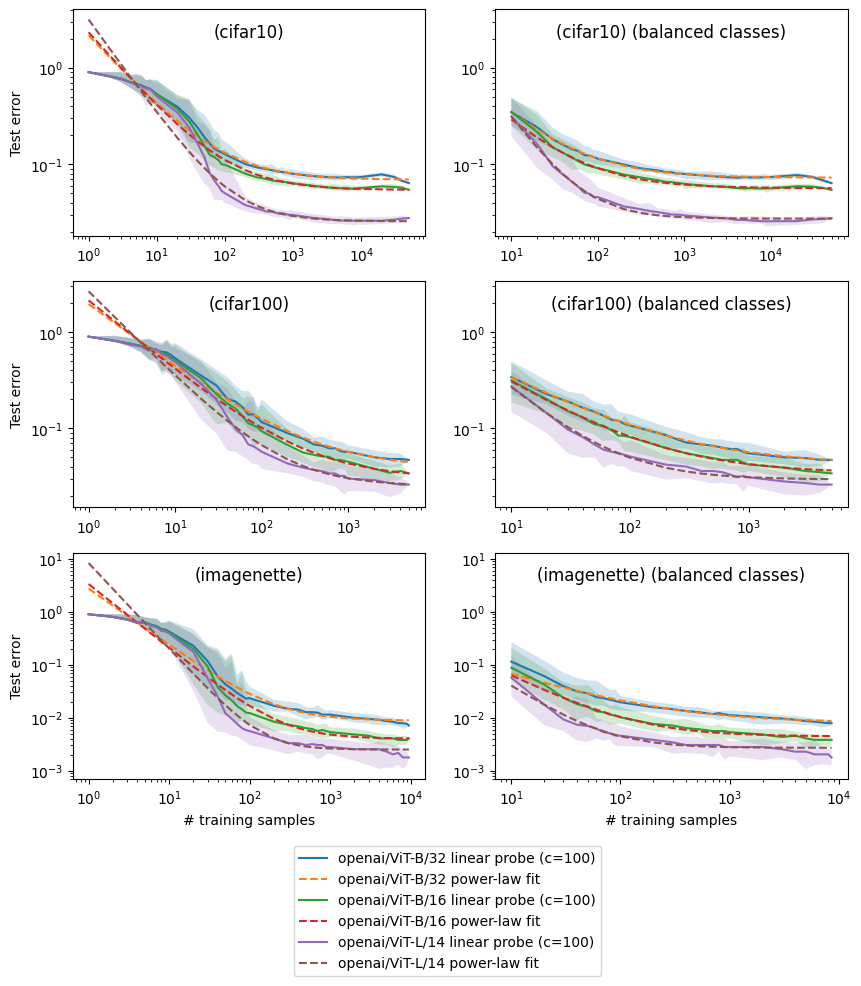

In [37]:
embedder_ids = [
    "openai/ViT-B/32",
    "openai/ViT-B/16",
    "openai/ViT-L/14",
]

last_ax: Optional[plt.Axes] = None
fig = plt.figure(figsize=(10, 10))
cur_subplot_idx = 1
for dataset_id in ("cifar10", "cifar100", "imagenette"):
    for per_class in (False, True):
        plt.subplot(3, 2, cur_subplot_idx)

        make_fancy_plot(
            embedder_ids=embedder_ids,
            dataset_id=dataset_id,
            per_class=per_class,
            n_random_inits=100,
        )
        if cur_subplot_idx % 2 == 0:
            assert last_ax is not None
            plt.ylim(last_ax.get_ylim())

        if cur_subplot_idx % 2 == 1:
            plt.ylabel("Test error")
        if cur_subplot_idx >= 5:
            plt.xlabel("# training samples")

        last_ax = plt.gca()
        cur_subplot_idx += 1

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 0.05))
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

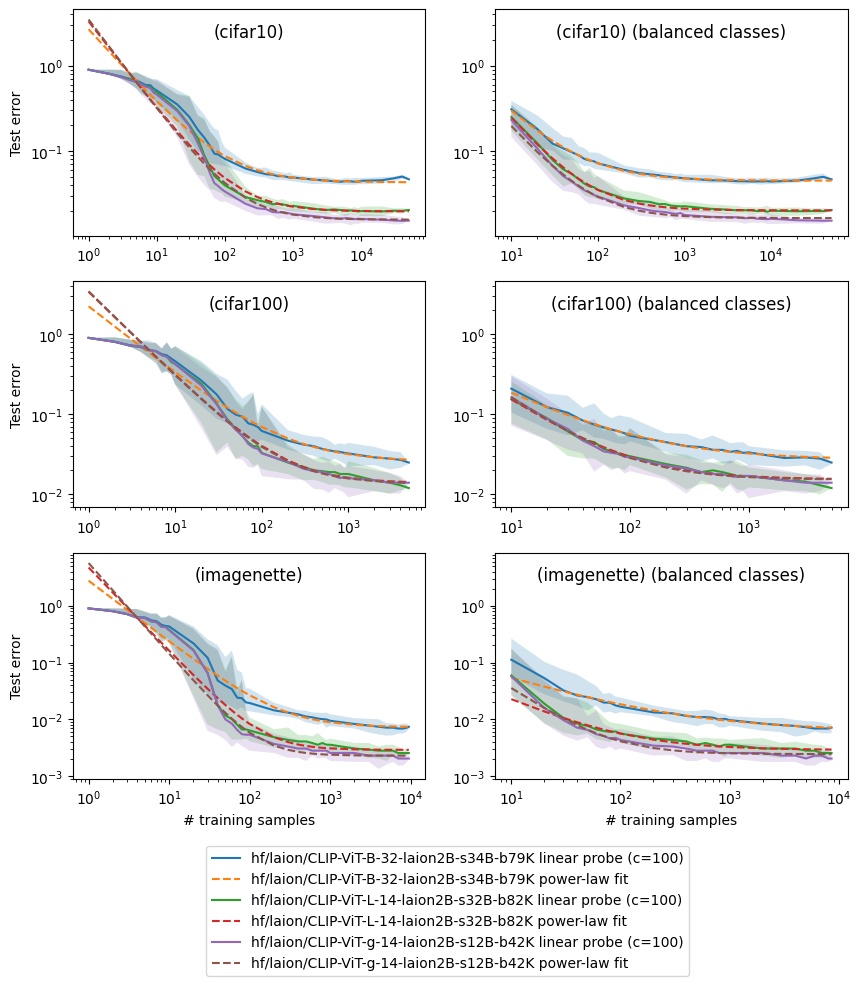

In [38]:
embedder_ids = [
    "hf/laion/CLIP-ViT-B-32-laion2B-s34B-b79K",
    "hf/laion/CLIP-ViT-L-14-laion2B-s32B-b82K",
    "hf/laion/CLIP-ViT-g-14-laion2B-s12B-b42K",
]

last_ax: Optional[plt.Axes] = None
fig = plt.figure(figsize=(10, 10))
cur_subplot_idx = 1
for dataset_id in ("cifar10", "cifar100", "imagenette"):
    for per_class in (False, True):
        plt.subplot(3, 2, cur_subplot_idx)

        make_fancy_plot(
            embedder_ids=embedder_ids,
            dataset_id=dataset_id,
            per_class=per_class,
            n_random_inits=100,
        )
        if cur_subplot_idx % 2 == 0:
            assert last_ax is not None
            plt.ylim(last_ax.get_ylim())

        if cur_subplot_idx % 2 == 1:
            plt.ylabel("Test error")
        if cur_subplot_idx >= 5:
            plt.xlabel("# training samples")

        last_ax = plt.gca()
        cur_subplot_idx += 1

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 0.05))
plt.show()